# User-Based Collaborative Filtering

## Overview
User-Based Collaborative Filtering (UBCF) recommends items by finding users with similar rating patterns. If User A and User B rate items similarly, items liked by User B can be recommended to User A. This approach uses Pearson correlation (cosine similarity on mean-centered data) to measure user similarity.

## Notebook Structure
1. **Setup**: Import libraries, configure paths, and detect phase (training/tuning vs final evaluation)
2. **Core Functions**: Data loading, sparse matrix construction, similarity computation, prediction, and recommendation
3. **Evaluation**: RMSE, accuracy, and ranking metrics (Recall@K, NDCG@K, MAP@K)
4. **Hyperparameter Tuning**: K-neighbor optimization on validation set with NDCG-primary selection strategy
5. **Pipeline Execution**: Automated training, tuning, and final evaluation with comprehensive visualizations

## Process Flow
**Phase 1 - Training & Tuning:**
- Load 5-core train split → Build user-item sparse matrix (CSR format)
- Compute user-user similarity via cosine on mean-centered ratings
- Test K values [5,10,20,30,50] on validation set → Select best K using NDCG@10 (primary), Recall@10 (tiebreaker)
- Save tuned model with optimal K

**Phase 2 - Final Evaluation:**
- Load tuned model → Evaluate on test set using best K
- Generate metrics: RMSE, Accuracy, Recall@K, NDCG@K, MAP@K for K∈{10,20,50}
- Create visualizations: tuning curves, final results, validation vs test comparison

In [21]:
import os, sys, json, pickle, time
import numpy as np, polars as pl
from pathlib import Path
from scipy.sparse import csr_matrix, save_npz, load_npz
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..', '../utilities'))
sys.path.append(module_path)

from logger import Logger
from configurations import Configurations
from visualization_helpers import (
    visualize_hyperparameter_tuning,
    visualize_final_results,
    visualize_val_test_comparison
)
from evaluation_metrics import compute_rmse_accuracy, recall_at_k, ndcg_at_k, map_at_k

logger = Logger(process_name="user_based", log_file=Configurations.LOG_PATH)

PROCESSED_DIR = Path(Configurations.DATA_PROCESSED_PATH)
MODELS_DIR = Path(Configurations.MODELS_PATH)
CATEGORY = Configurations.CATEGORIES

has_tuning = Configurations.has_tuning_results_user(CATEGORY[0])
K_VALUES = Configurations.K_VALUES_COARSE
PHASE = 'final' if has_tuning else 'train_tune'

logger.log_info("="*70)
logger.log_info(f"PHASE: {'FINAL EVALUATION' if has_tuning else 'TRAINING + TUNING'}")
logger.log_info(f"Categories: {CATEGORY} | Sample: {Configurations.DEV_SAMPLE_SIZE}")
if not has_tuning:
    logger.log_info(f"K values: {K_VALUES}")
logger.log_info("="*70 + "\n")

N_RECS = 10
MEAN_CENTER = True
MAX_USERS = None
MAX_ITEMS = None

2025-10-26 01:46:02,034 - INFO - ======================================================================
2025-10-26 01:46:02,037 - INFO - PHASE: TRAINING + TUNING
2025-10-26 01:46:02,039 - INFO - Categories: ['Electronics', 'Beauty_and_Personal_Care', 'Sports_and_Outdoors'] | Sample: big
2025-10-26 01:46:02,040 - INFO - K values: [10, 20, 50, 100, 150, 200]
2025-10-26 01:46:02,043 - INFO - ======================================================================



In [22]:
def _candidate_files(category: str, split: str = "train"):
    dev_sample = Configurations.DEV_SAMPLE_SIZE
    if dev_sample != 'full':
        for size_name in Configurations.SAMPLE_SIZES.keys():
            if size_name == dev_sample:
                return PROCESSED_DIR / f"{category.replace('/', '-')}.5core.{split}.{size_name}.parquet"
    return PROCESSED_DIR / f"{category.replace('/', '-')}.5core.{split}.parquet"

def load_5core_data(category: str, split: str = "train") -> pl.DataFrame:
    p = _candidate_files(category, split)
    df = pl.read_parquet(p, low_memory=False)
    logger.log_info(f"[{split.upper()}] shape={df.shape} | users={df['user_id'].n_unique()} | items={df['parent_asin'].n_unique()}")
    return df

In [23]:
def build_user_matrices(df_train: pl.DataFrame, mean_center: bool = True, max_users: int | None = None, max_items: int | None = None):
    df = df_train.select(['user_id', 'parent_asin', 'rating']).with_columns(pl.col('rating').cast(pl.Float32))
    if max_users:
        df = df.filter(pl.col('user_id').is_in(df['user_id'].unique()[:max_users]))
    if max_items:
        df = df.filter(pl.col('parent_asin').is_in(df['parent_asin'].unique()[:max_items]))
    
    user_rev = df['user_id'].unique().to_list()
    item_rev = df['parent_asin'].unique().to_list()
    user_idx = {u: i for i, u in enumerate(user_rev)}
    item_idx = {a: i for i, a in enumerate(item_rev)}
    
    u = np.array([user_idx[x] for x in df['user_id'].to_list()], dtype=np.int32)
    i = np.array([item_idx[x] for x in df['parent_asin'].to_list()], dtype=np.int32)
    v = np.array(df['rating'].to_list(), dtype=np.float32)
    
    nU, nI = len(user_rev), len(item_rev)
    R = csr_matrix((v, (u, i)), shape=(nU, nI), dtype=np.float32)
    
    user_means = np.zeros(nU, dtype=np.float32)
    Rc = None
    if mean_center:
        Rc = R.copy().astype(np.float32)
        row_sums = np.array(R.sum(axis=1)).ravel().astype(np.float32)
        row_cnts = np.diff(R.indptr).astype(np.int32)
        with np.errstate(divide='ignore', invalid='ignore'):
            user_means = np.where(row_cnts > 0, row_sums / row_cnts, 0.0).astype(np.float32)
        if Rc.nnz:
            Rc.data -= np.repeat(user_means, row_cnts)
    
    logger.log_info(f"[Matrix] R{R.shape} nnz={R.nnz}")
    return R, Rc, user_idx, item_idx, np.array(user_rev, dtype=object), np.array(item_rev, dtype=object), user_means

In [24]:
def fit_user_neighbors(X: csr_matrix, k_neighbors: int = 30):
    similarity = cosine_similarity(X, dense_output=True)
    np.fill_diagonal(similarity, 0)
    similarity[similarity < 0] = 0
    logger.log_info(f"[Similarity] {similarity.shape}, non-zero: {np.count_nonzero(similarity):,}")
    return {'similarity': similarity, 'k_neighbors': k_neighbors, 'type': 'precomputed'}

In [25]:
def save_user_artifacts(out_dir: Path, R, Rc, user_means, user_rev, item_rev, user_idx, item_idx, nn_model):
    out_dir.mkdir(parents=True, exist_ok=True)
    save_npz(out_dir / "R.npz", R)
    if Rc is not None:
        save_npz(out_dir / "Rc.npz", Rc)
    np.save(out_dir / "user_means.npy", user_means)
    with open(out_dir / "user_rev.pkl", "wb") as f: pickle.dump(user_rev, f)
    with open(out_dir / "item_rev.pkl", "wb") as f: pickle.dump(item_rev, f)
    (out_dir / "user_idx.json").write_text(json.dumps({str(k): int(v) for k, v in user_idx.items()}))
    (out_dir / "item_idx.json").write_text(json.dumps({str(k): int(v) for k, v in item_idx.items()}))
    with open(out_dir / "nn_model.pkl", "wb") as f: pickle.dump(nn_model, f)

def load_user_artifacts(model_dir: str | Path):
    md = Path(model_dir)
    R = load_npz(md / "R.npz")
    Rc = load_npz(md / "Rc.npz") if (md / "Rc.npz").exists() else None
    user_means = np.load(md / "user_means.npy")
    with open(md / "user_rev.pkl", "rb") as f: user_rev = pickle.load(f)
    with open(md / "item_rev.pkl", "rb") as f: item_rev = pickle.load(f)
    user_idx = {k: int(v) for k, v in json.loads((md / "user_idx.json").read_text()).items()}
    item_idx = {k: int(v) for k, v in json.loads((md / "item_idx.json").read_text()).items()}
    with open(md / "nn_model.pkl", "rb") as f: nn_model = pickle.load(f)
    return dict(R=R, Rc=Rc, user_means=user_means, user_rev=user_rev, item_rev=item_rev, user_idx=user_idx, item_idx=item_idx, nn_model=nn_model)

In [26]:
def predict_user_based(user_idx_val: int, R: csr_matrix, Rc: csr_matrix | None, 
                      nn_model, user_means: np.ndarray, k_neighbors: int = 30) -> np.ndarray:
    X = Rc if Rc is not None else R
    
    if isinstance(nn_model, dict) and 'similarity' in nn_model:
        user_sims = nn_model['similarity'][user_idx_val]
        top_k_indices = np.argsort(-user_sims)[:k_neighbors]
        idx, sims = top_k_indices, user_sims[top_k_indices]
    else:
        distances, indices = nn_model.kneighbors(X.getrow(user_idx_val), return_distance=True)
        d, idx = distances.ravel(), indices.ravel()
        mask = idx != user_idx_val
        idx, d = idx[mask][:k_neighbors], d[mask][:k_neighbors]
        sims = np.clip(1.0 - d, 0.0, 1.0)
    
    if idx.size == 0:
        return np.zeros(R.shape[1], dtype=np.float32)
    
    sims = np.clip(sims, 0, None)
    denom = np.sum(np.abs(sims)) + 1e-8
    scores = X[idx, :].T.dot(sims) / denom
    
    if Rc is not None:
        scores = scores + user_means[user_idx_val]
    
    return scores

def recommend_user_based(user_id: str, n_recs: int, artifacts: dict) -> pl.DataFrame:
    R, Rc = artifacts['R'], artifacts.get('Rc')
    user_idx, item_rev = artifacts['user_idx'], artifacts['item_rev']
    user_means, nn_model = artifacts['user_means'], artifacts['nn_model']
    k_neighbors = artifacts.get('k_neighbors', 30)
    
    if user_id not in user_idx:
        return pl.DataFrame(columns=["parent_asin", "score"])
    
    u = user_idx[user_id]
    scores = predict_user_based(u, R, Rc, nn_model, user_means, k_neighbors=k_neighbors)
    rated = set(R.getrow(u).indices.tolist())
    cand_mask = np.ones(R.shape[1], dtype=bool)
    if rated:
        cand_mask[list(rated)] = False
    
    cand_scores = scores[cand_mask]
    if cand_scores.size == 0:
        return pl.DataFrame(columns=["parent_asin", "score"])
    
    n_top = min(n_recs, cand_scores.size)
    cand_indices = np.nonzero(cand_mask)[0]
    top_pos = np.argpartition(-cand_scores, n_top - 1)[:n_top]
    picked = sorted([(int(cand_indices[p]), float(cand_scores[p])) for p in top_pos], key=lambda x: -x[1])
    
    return pl.DataFrame({"parent_asin": [item_rev[i] for i, _ in picked], "score": [s for _, s in picked]})

In [27]:
def evaluate_user_based(category: str, artifacts: dict, k_values: list = [10, 20, 50], 
                       split: str = "test", sample_users: int = 3000):
    df_eval = load_5core_data(category, split=split)
    train_users = list(artifacts['user_idx'].keys())
    df_eval = df_eval.filter(pl.col('user_id').is_in(train_users))
    
    if len(df_eval) == 0:
        return None
    
    eval_users = df_eval['user_id'].unique().to_list()
    if len(eval_users) > sample_users:
        np.random.seed(42)
        eval_users = np.random.choice(eval_users, size=sample_users, replace=False).tolist()
    
    metrics_acc = {'rmse': [], 'accuracy': [], **{f'{m}@{k}': [] for m in ['recall', 'ndcg', 'map'] for k in k_values}}
    k_neighbors = artifacts.get('k_neighbors', 30)
    R, item_idx, item_rev = artifacts['R'], artifacts['item_idx'], artifacts['item_rev']
    
    for user_id in eval_users:
        if user_id not in artifacts['user_idx']:
            continue
        
        u = artifacts['user_idx'][user_id]
        user_eval = df_eval.filter(pl.col('user_id') == user_id)
        actual_items = set(user_eval['parent_asin'].to_list())
        known_items = {item for item in actual_items if item in item_idx}
        
        if not known_items:
            continue
        
        actual_ratings = {row['parent_asin']: row['rating'] for row in user_eval.iter_rows(named=True)}
        scores = predict_user_based(u, R, artifacts.get('Rc'), artifacts['nn_model'], artifacts['user_means'], k_neighbors)
        
        predictions = np.full(R.shape[1], np.nan)
        actuals = np.full(R.shape[1], np.nan)
        for asin in known_items:
            idx = item_idx[asin]
            predictions[idx] = scores[idx]
            actuals[idx] = actual_ratings[asin]
        
        rmse, acc = compute_rmse_accuracy(predictions, actuals)
        if not np.isnan(rmse):
            metrics_acc['rmse'].append(rmse)
            metrics_acc['accuracy'].append(acc)
        
        rated = set(R.getrow(u).indices.tolist())
        cand_mask = np.ones(R.shape[1], dtype=bool)
        if rated:
            cand_mask[list(rated)] = False
        
        cand_scores = scores[cand_mask]
        if cand_scores.size == 0:
            continue
        
        cand_indices = np.nonzero(cand_mask)[0]
        max_k = max(k_values)
        n_top = min(max_k, cand_scores.size)
        top_pos = np.argpartition(-cand_scores, n_top - 1)[:n_top]
        sorted_idx = top_pos[np.argsort(-cand_scores[top_pos])]
        recommended = [item_rev[cand_indices[i]] for i in sorted_idx]
        
        for k in k_values:
            metrics_acc[f'recall@{k}'].append(recall_at_k(recommended, known_items, k))
            metrics_acc[f'ndcg@{k}'].append(ndcg_at_k(recommended, known_items, k))
            metrics_acc[f'map@{k}'].append(map_at_k(recommended, known_items, k))
    
    results = {'category': category, 'split': split, 'n_users': len(eval_users),
               'rmse': np.mean(metrics_acc['rmse']) if metrics_acc['rmse'] else np.nan,
               'accuracy': np.mean(metrics_acc['accuracy']) if metrics_acc['accuracy'] else np.nan}
    
    for k in k_values:
        for metric in ['recall', 'ndcg', 'map']:
            key = f'{metric}@{k}'
            results[key] = np.mean(metrics_acc[key]) if metrics_acc[key] else 0.0
    
    logger.log_info(f"[Eval] RMSE={results['rmse']:.4f}, NDCG@10={results['ndcg@10']:.4f}")
    return results

In [28]:
def select_best_k(df_results: pl.DataFrame):
    best_k_ndcg = df_results['K'][df_results['NDCG@10'].arg_max()]
    best_ndcg = df_results['NDCG@10'].max()
    threshold = best_ndcg * 0.98
    similar_rows = df_results.filter(pl.col('NDCG@10') >= threshold)
    
    if len(similar_rows) > 1:
        best_k = similar_rows['K'][similar_rows['RECALL@10'].arg_max()]
        logger.log_info(f"Selected K={best_k} (NDCG tiebreak with Recall)")
    else:
        best_k = best_k_ndcg
        logger.log_info(f"Selected K={best_k} (highest NDCG@10)")
    
    return best_k

In [29]:
def _train_single_category(cat, model_dir, K_VALUES, n_eval_tune):
    if not (model_dir / "R.npz").exists():
        logger.log_info("[Train] Building base model...")
        df_train = load_5core_data(cat, split="train")
        R, Rc, user_idx, item_idx, user_rev, item_rev, user_means = build_user_matrices(
            df_train, mean_center=MEAN_CENTER, max_users=MAX_USERS, max_items=MAX_ITEMS
        )
        X = Rc if Rc is not None else R
        nn_model = fit_user_neighbors(X, k_neighbors=30)
        save_user_artifacts(model_dir, R, Rc, user_means, user_rev, item_rev, user_idx, item_idx, nn_model)
    
    if not Configurations.has_tuning_results_user(cat):
        logger.log_info("[Tune] Starting hyperparameter tuning...")
        artifacts = load_user_artifacts(model_dir)
        X = artifacts['Rc'] if artifacts['Rc'] is not None else artifacts['R']
        
        results = []
        for k in K_VALUES:
            nn_model = fit_user_neighbors(X, k_neighbors=k)
            eval_artifacts = {**{k: artifacts[k] for k in ['R', 'Rc', 'user_means', 'user_rev', 'item_rev', 'user_idx', 'item_idx']}, 
                            'nn_model': nn_model, 'k_neighbors': k}
            metrics = evaluate_user_based(cat, eval_artifacts, k_values=[10, 20, 50], split="valid", sample_users=n_eval_tune)
            
            if metrics:
                results.append({'K': k, **{f'{m.upper()}@{kv}': metrics[f'{m}@{kv}'] 
                    for m in ['ndcg', 'recall', 'map'] for kv in [10, 20, 50]},
                    'RMSE': metrics['rmse'], 'Accuracy': metrics['accuracy']})
        
        df_results = pl.DataFrame(results)
        df_results.write_csv(MODELS_DIR / 'user' / f'tuning_{cat}.csv')
        best_k = select_best_k(df_results)
        Configurations.save_best_k(cat, best_k)
        
        visualize_hyperparameter_tuning(df_results, category=cat, param_col='K', 
            param_name='K (Neighbors)', save_dir=MODELS_DIR / 'user', algo_name='User-Based')
        
        nn_model_best = fit_user_neighbors(X, k_neighbors=best_k)
        save_user_artifacts(model_dir, artifacts['R'], artifacts['Rc'], artifacts['user_means'],
                          artifacts['user_rev'], artifacts['item_rev'], artifacts['user_idx'], 
                          artifacts['item_idx'], nn_model_best)
        return {'tuned_now': True, 'best_k': best_k}
    
    return {'tuned_now': False, 'best_k': Configurations.load_best_k(cat)}

2025-10-26 01:46:02,484 - INFO - PHASE 1: TRAINING + TUNING

2025-10-26 01:46:02,510 - INFO - 
Electronics
2025-10-26 01:46:02,514 - INFO - [Train] Building base model...
2025-10-26 01:46:02,567 - INFO - [TRAIN] shape=(85890, 4) | users=35494 | items=82
2025-10-26 01:46:02,695 - INFO - [Matrix] R(35494, 82) nnz=85890
2025-10-26 01:46:12,596 - INFO - [Similarity] (35494, 35494), non-zero: 9,137,852
2025-10-26 01:46:20,598 - INFO - [Tune] Starting hyperparameter tuning...
2025-10-26 01:46:32,144 - INFO - [Similarity] (35494, 35494), non-zero: 9,137,852
2025-10-26 01:46:32,247 - INFO - [VALID] shape=(858, 4) | users=858 | items=81
2025-10-26 01:46:33,481 - INFO - [Eval] RMSE=0.6156, NDCG@10=0.0651
2025-10-26 01:46:41,053 - INFO - [Similarity] (35494, 35494), non-zero: 9,137,852
2025-10-26 01:46:41,080 - INFO - [VALID] shape=(858, 4) | users=858 | items=81
2025-10-26 01:46:42,585 - INFO - [Eval] RMSE=0.6153, NDCG@10=0.0695
2025-10-26 01:46:52,649 - INFO - [Similarity] (35494, 35494), non-z

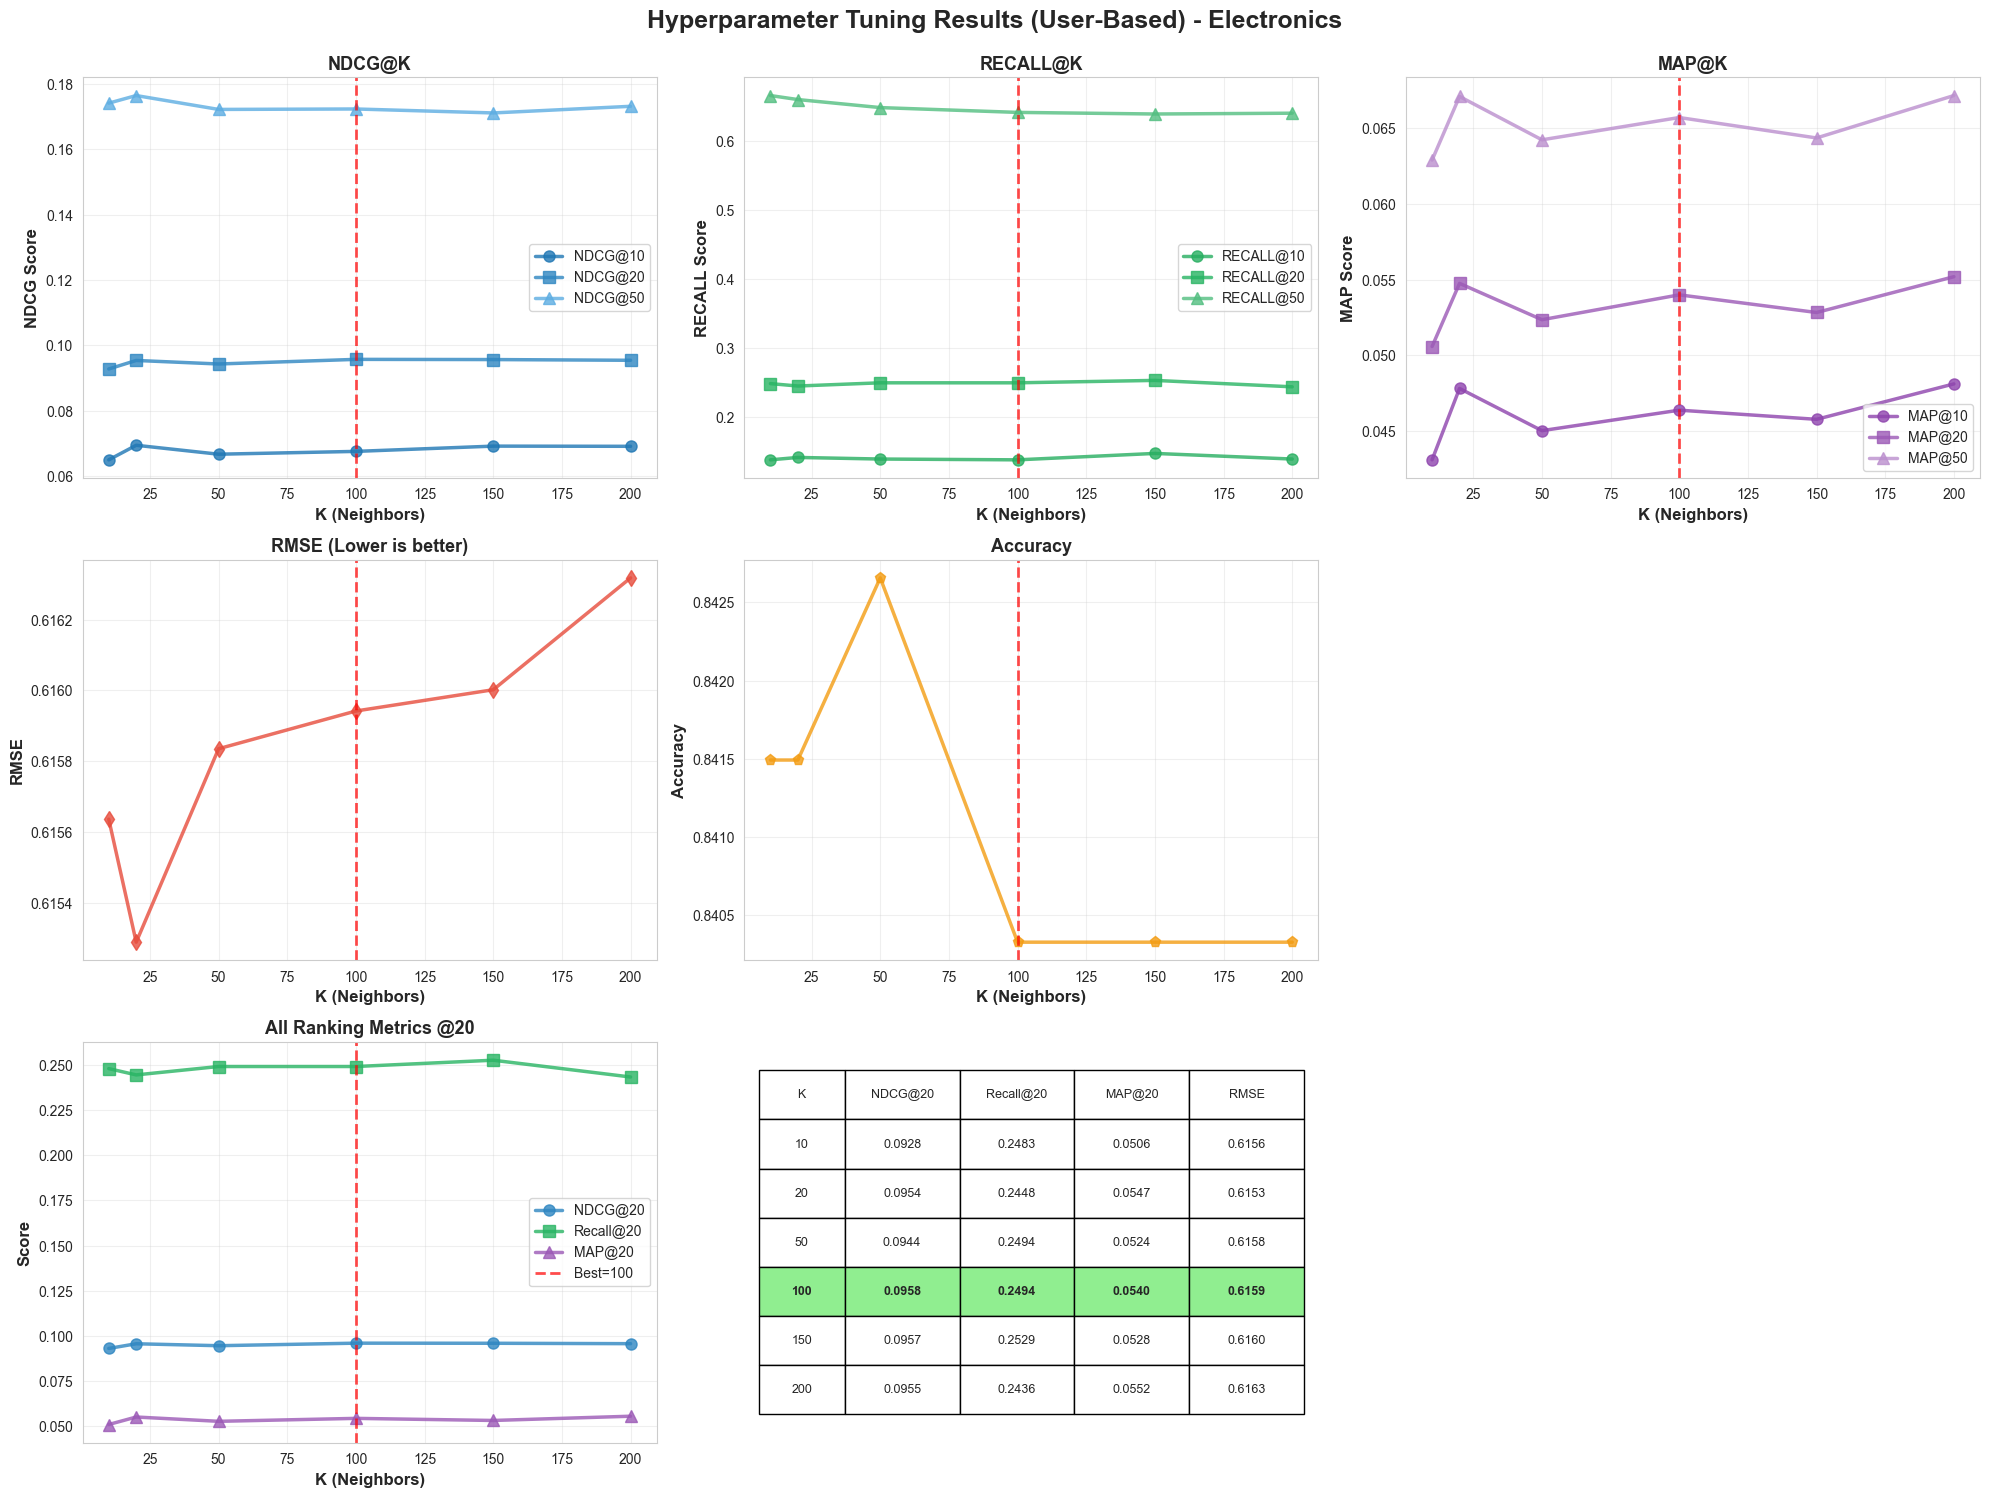

2025-10-26 01:47:32,699 - INFO - [Similarity] (35494, 35494), non-zero: 9,137,852
2025-10-26 01:47:40,065 - INFO - 
Beauty_and_Personal_Care
2025-10-26 01:47:40,069 - INFO - [Train] Building base model...
2025-10-26 01:47:40,075 - INFO - [TRAIN] shape=(7718, 4) | users=6613 | items=8
2025-10-26 01:47:40,090 - INFO - [Matrix] R(6613, 8) nnz=7718
2025-10-26 01:47:40,199 - INFO - [Similarity] (6613, 6613), non-zero: 66,752
2025-10-26 01:47:40,323 - INFO - [Tune] Starting hyperparameter tuning...
2025-10-26 01:47:40,556 - INFO - [Similarity] (6613, 6613), non-zero: 66,752
2025-10-26 01:47:40,561 - INFO - [VALID] shape=(66, 4) | users=66 | items=8
2025-10-26 01:47:40,684 - INFO - [Eval] RMSE=0.9430, NDCG@10=0.4802
2025-10-26 01:47:40,843 - INFO - [Similarity] (6613, 6613), non-zero: 66,752
2025-10-26 01:47:40,848 - INFO - [VALID] shape=(66, 4) | users=66 | items=8
2025-10-26 01:47:40,898 - INFO - [Eval] RMSE=0.9416, NDCG@10=0.4720
2025-10-26 01:47:41,009 - INFO - [Similarity] (6613, 6613), 

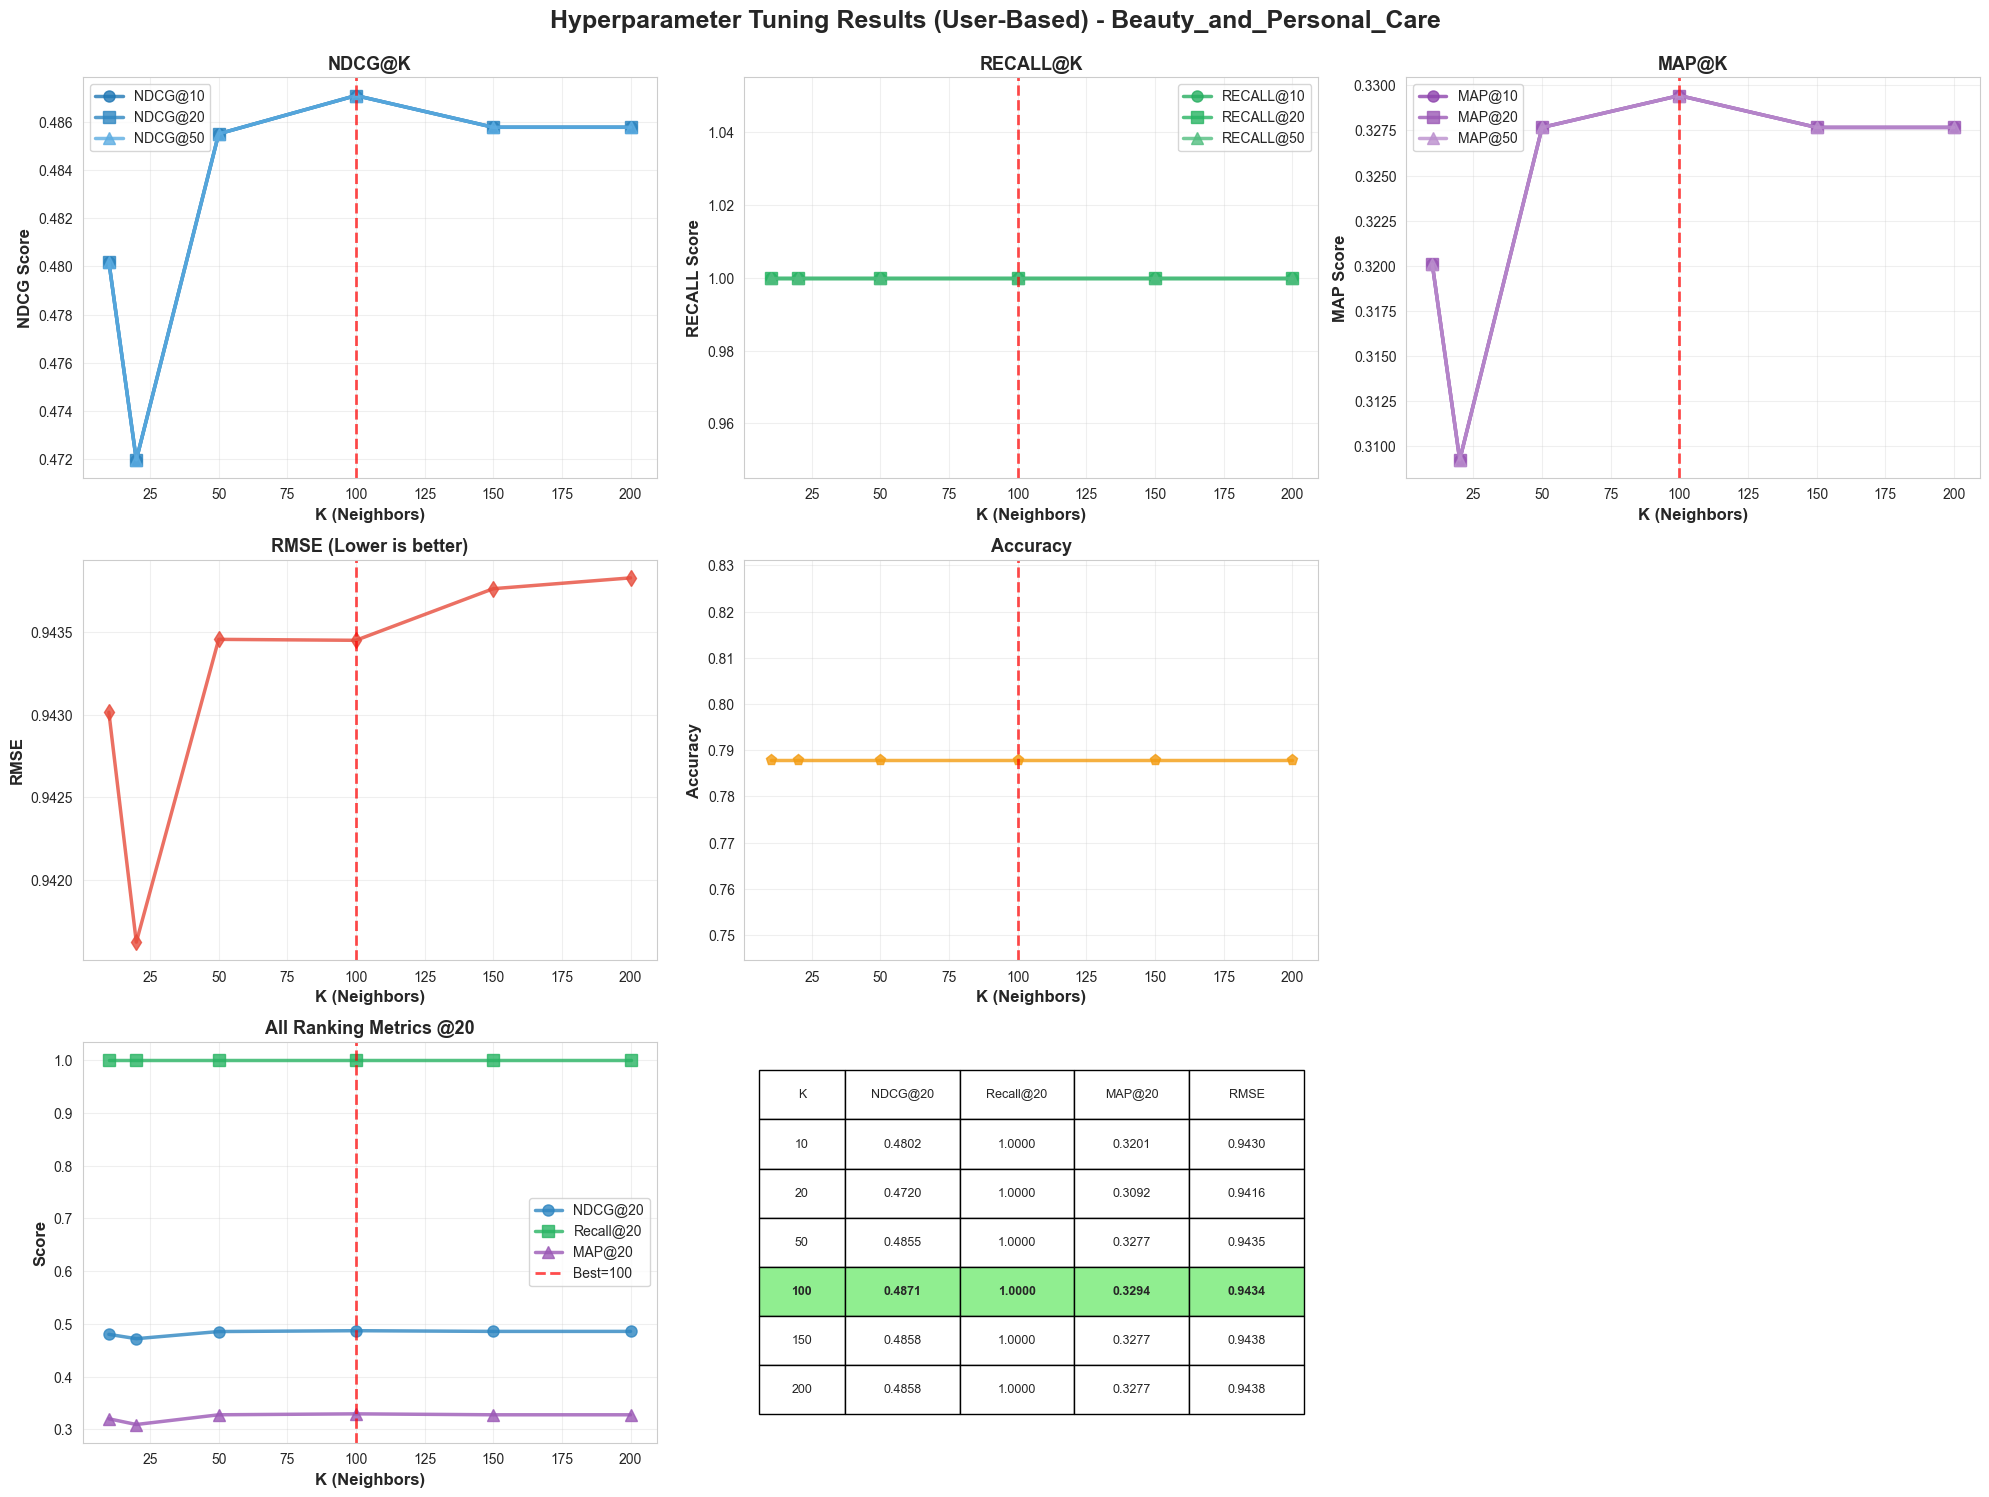

2025-10-26 01:47:42,892 - INFO - [Similarity] (6613, 6613), non-zero: 66,752
2025-10-26 01:47:43,118 - INFO - 
Sports_and_Outdoors
2025-10-26 01:47:43,119 - INFO - [Train] Building base model...
2025-10-26 01:47:43,134 - INFO - [TRAIN] shape=(3250, 4) | users=3079 | items=3
2025-10-26 01:47:43,152 - INFO - [Matrix] R(3079, 3) nnz=3250
2025-10-26 01:47:43,204 - INFO - [Similarity] (3079, 3079), non-zero: 1,246
2025-10-26 01:47:43,254 - INFO - [Tune] Starting hyperparameter tuning...
2025-10-26 01:47:43,345 - INFO - [Similarity] (3079, 3079), non-zero: 1,246
2025-10-26 01:47:43,361 - INFO - [VALID] shape=(15, 4) | users=15 | items=3
2025-10-26 01:47:43,413 - INFO - [Eval] RMSE=0.5333, NDCG@10=0.7293
2025-10-26 01:47:43,497 - INFO - [Similarity] (3079, 3079), non-zero: 1,246
2025-10-26 01:47:43,519 - INFO - [VALID] shape=(15, 4) | users=15 | items=3
2025-10-26 01:47:43,538 - INFO - [Eval] RMSE=0.5333, NDCG@10=0.7293
2025-10-26 01:47:43,574 - INFO - [Similarity] (3079, 3079), non-zero: 1,2

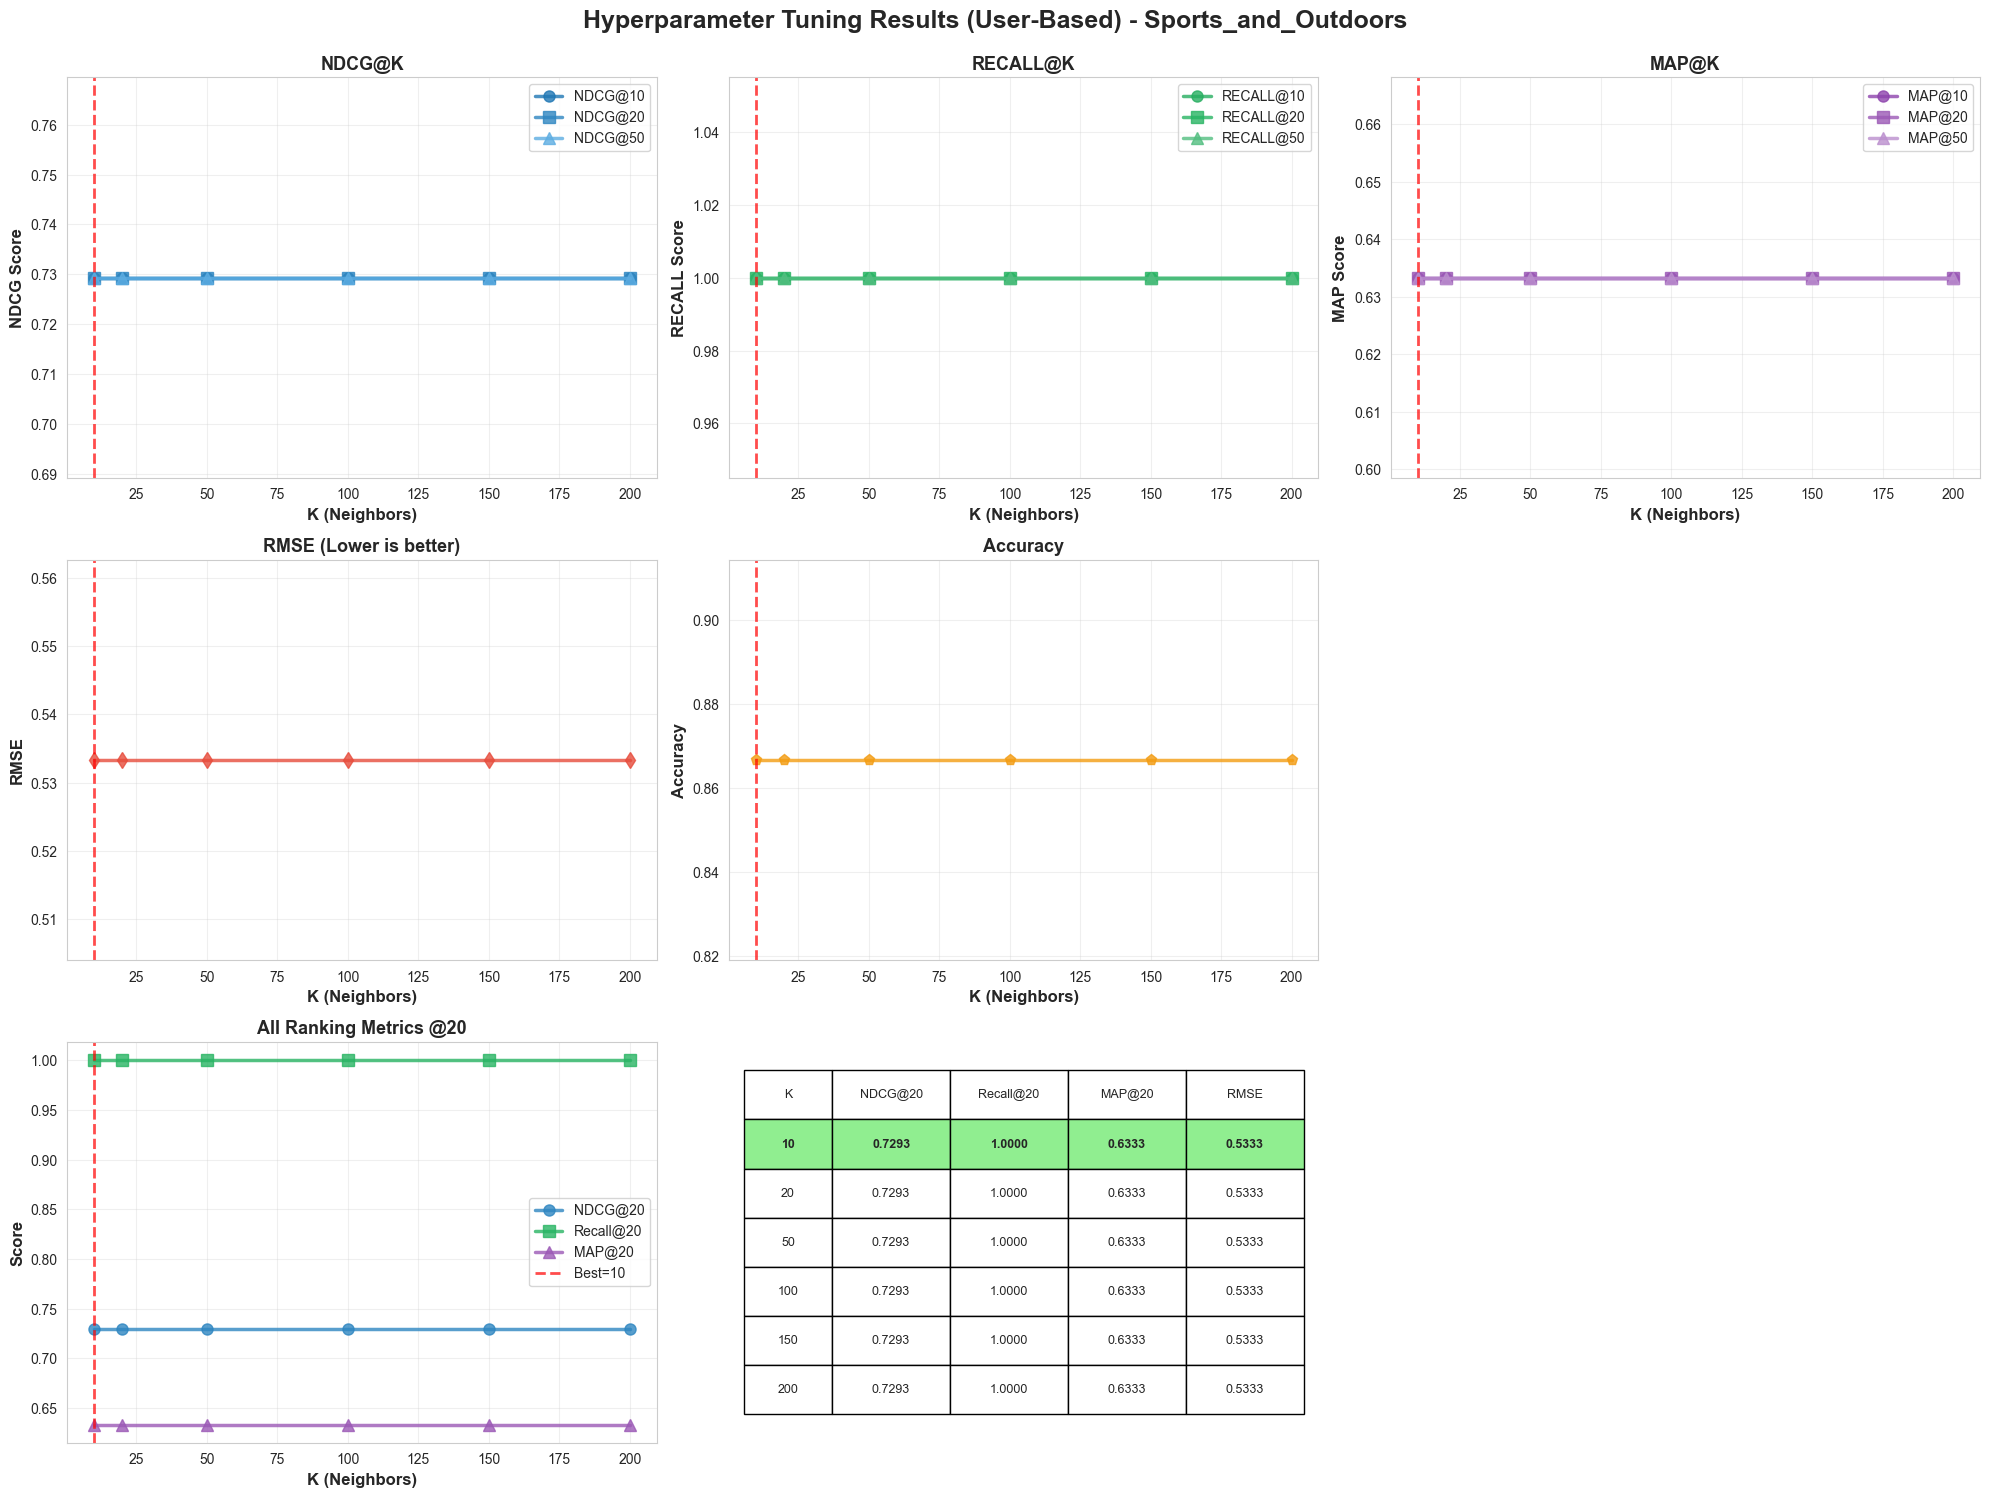

2025-10-26 01:47:44,952 - INFO - [Similarity] (3079, 3079), non-zero: 1,246
2025-10-26 01:47:45,001 - INFO - 
PHASE 1 COMPLETE
2025-10-26 01:47:45,002 - INFO -   Electronics: K=150 (tuned)
2025-10-26 01:47:45,002 - INFO -   Beauty_and_Personal_Care: K=10 (tuned)
2025-10-26 01:47:45,002 - INFO -   Sports_and_Outdoors: K=10 (tuned)


In [30]:
logger.log_info("PHASE 1: TRAINING + TUNING\n")
workflow_results = {}

for cat in CATEGORY:
    logger.log_info(f"\n{'='*70}\n{cat}\n{'='*70}")
    model_dir = MODELS_DIR / "user" / cat
    workflow_results[cat] = _train_single_category(cat, model_dir, K_VALUES, Configurations.get_eval_samples_tuning())

logger.log_info("\nPHASE 1 COMPLETE")
for cat in CATEGORY:
    status = 'tuned' if workflow_results[cat]['tuned_now'] else 'cached'
    logger.log_info(f"  {cat}: K={workflow_results[cat]['best_k']} ({status})")

2025-10-26 01:47:45,016 - INFO - 
PHASE 2: FINAL EVALUATION

2025-10-26 01:47:45,019 - INFO - 
Electronics (K=150)
2025-10-26 01:47:47,236 - INFO - [TEST] shape=(675, 4) | users=675 | items=76
2025-10-26 01:47:48,235 - INFO - [Eval] RMSE=0.6761, NDCG@10=0.0779
2025-10-26 01:47:48,236 - INFO - 
Beauty_and_Personal_Care (K=10)
2025-10-26 01:47:48,376 - INFO - [TEST] shape=(65, 4) | users=65 | items=8
2025-10-26 01:47:48,419 - INFO - [Eval] RMSE=1.0380, NDCG@10=0.5073
2025-10-26 01:47:48,420 - INFO - 
Sports_and_Outdoors (K=10)
2025-10-26 01:47:48,439 - INFO - [TEST] shape=(11, 4) | users=11 | items=3
2025-10-26 01:47:48,448 - INFO - [Eval] RMSE=0.5455, NDCG@10=0.7316


category,split,n_users,rmse,accuracy,recall@10,ndcg@10,map@10,recall@20,ndcg@20,map@20,recall@50,ndcg@50,map@50
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Electronics""","""test""",675,0.676089,0.826667,0.151111,0.077909,0.055432,0.251852,0.102653,0.061849,0.64,0.178517,0.073586
"""Beauty_and_Personal_Care""","""test""",65,1.037982,0.723077,1.0,0.507344,0.353773,1.0,0.507344,0.353773,1.0,0.507344,0.353773
"""Sports_and_Outdoors""","""test""",11,0.545455,0.818182,1.0,0.731585,0.636364,1.0,0.731585,0.636364,1.0,0.731585,0.636364


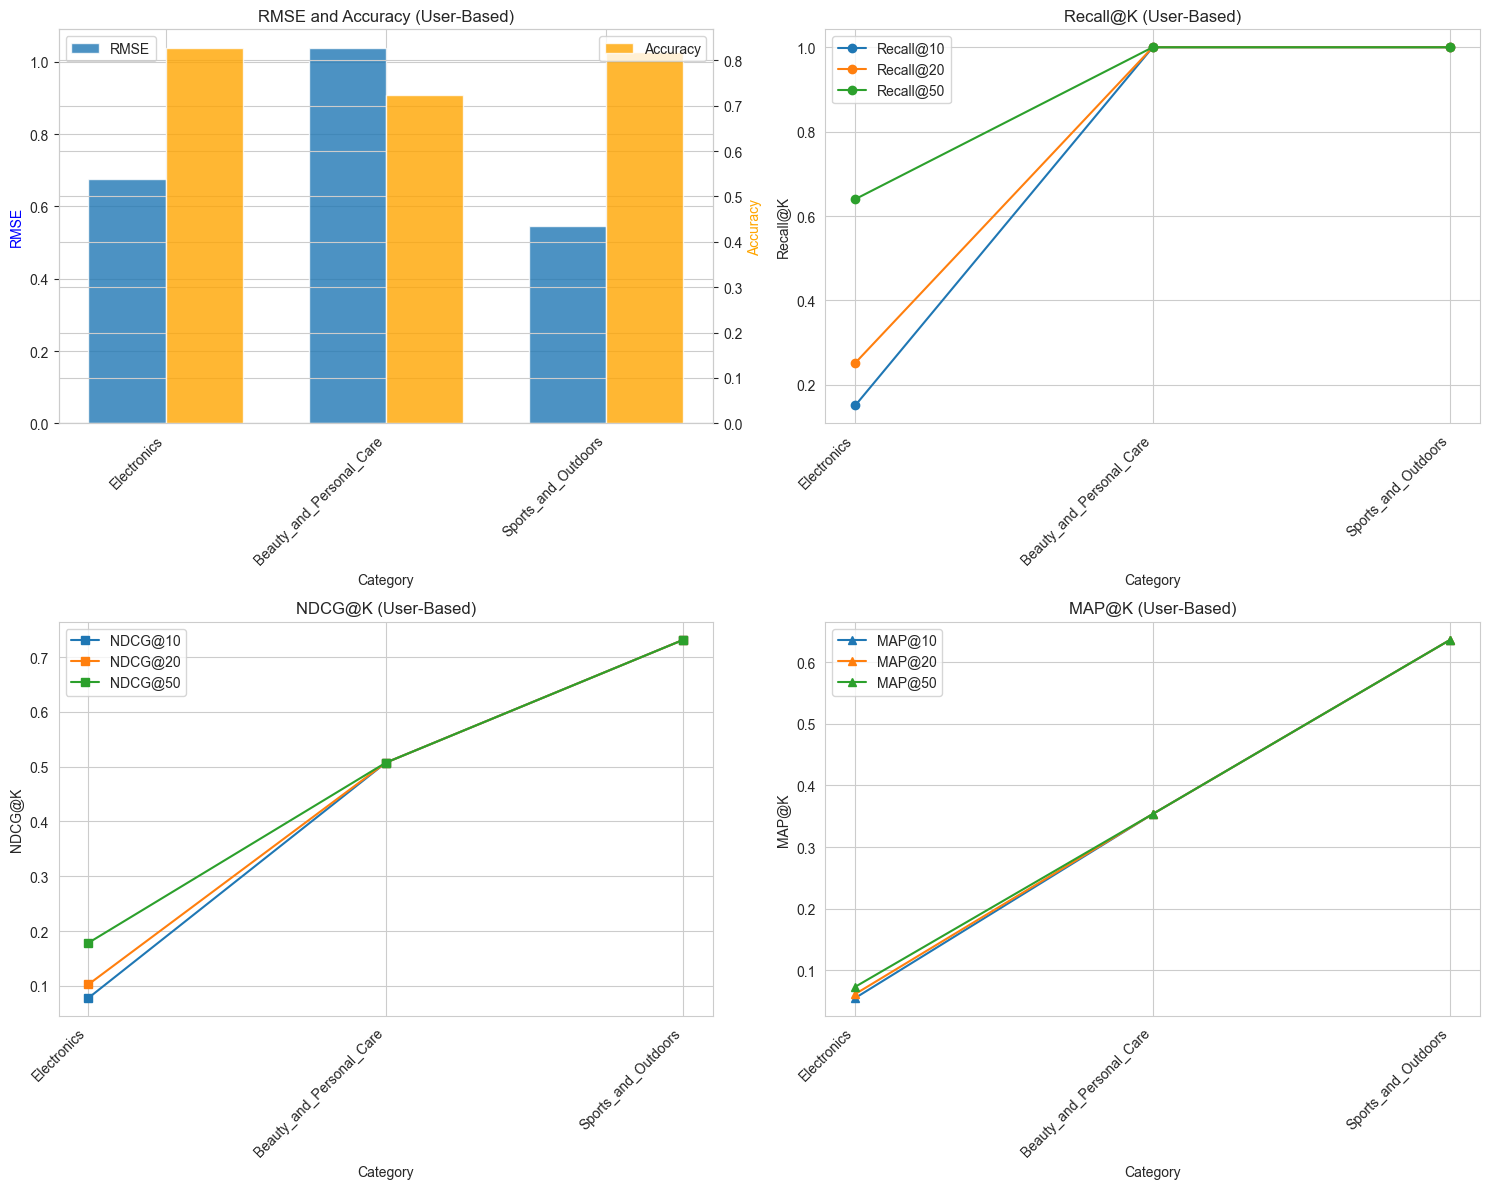

shape: (1, 12)
┌─────┬──────────┬──────────┬──────────┬───┬──────────┬──────────┬──────────┬──────────┐
│ K   ┆ NDCG@10  ┆ NDCG@20  ┆ NDCG@50  ┆ … ┆ MAP@20   ┆ MAP@50   ┆ RMSE     ┆ Accuracy │
│ --- ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ i64 ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞═════╪══════════╪══════════╪══════════╪═══╪══════════╪══════════╪══════════╪══════════╡
│ 150 ┆ 0.069268 ┆ 0.095702 ┆ 0.171017 ┆ … ┆ 0.052828 ┆ 0.064339 ┆ 0.616002 ┆ 0.840326 │
└─────┴──────────┴──────────┴──────────┴───┴──────────┴──────────┴──────────┴──────────┘


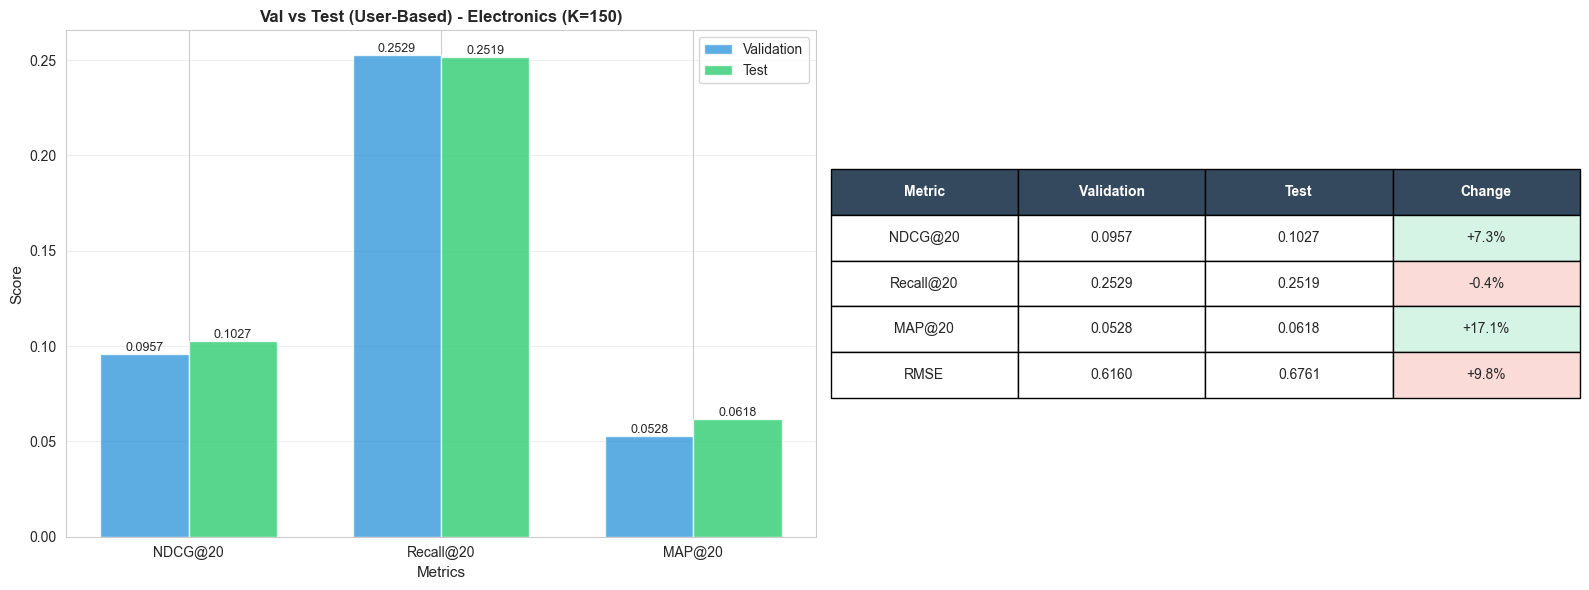

shape: (1, 12)
┌─────┬──────────┬──────────┬──────────┬───┬──────────┬──────────┬──────────┬──────────┐
│ K   ┆ NDCG@10  ┆ NDCG@20  ┆ NDCG@50  ┆ … ┆ MAP@20   ┆ MAP@50   ┆ RMSE     ┆ Accuracy │
│ --- ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ i64 ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞═════╪══════════╪══════════╪══════════╪═══╪══════════╪══════════╪══════════╪══════════╡
│ 10  ┆ 0.480198 ┆ 0.480198 ┆ 0.480198 ┆ … ┆ 0.320094 ┆ 0.320094 ┆ 0.943014 ┆ 0.787879 │
└─────┴──────────┴──────────┴──────────┴───┴──────────┴──────────┴──────────┴──────────┘


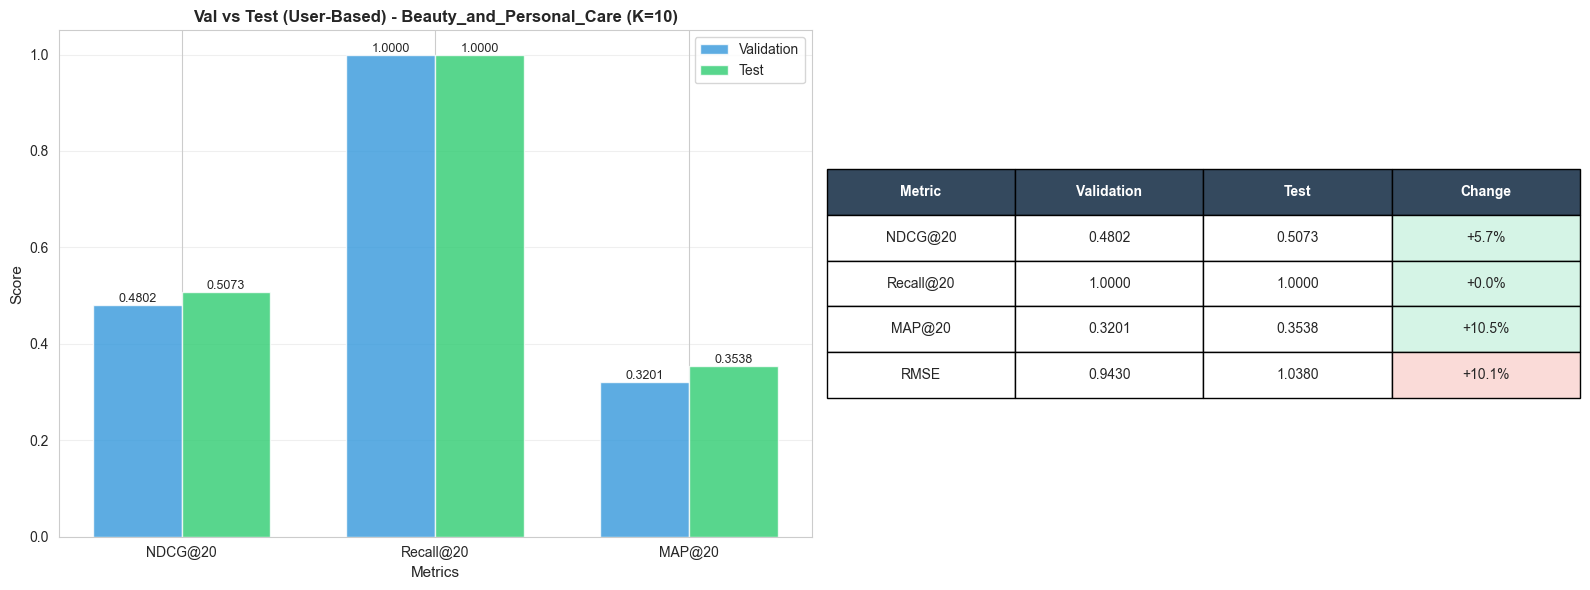

shape: (1, 12)
┌─────┬──────────┬──────────┬──────────┬───┬──────────┬──────────┬──────────┬──────────┐
│ K   ┆ NDCG@10  ┆ NDCG@20  ┆ NDCG@50  ┆ … ┆ MAP@20   ┆ MAP@50   ┆ RMSE     ┆ Accuracy │
│ --- ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ i64 ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞═════╪══════════╪══════════╪══════════╪═══╪══════════╪══════════╪══════════╪══════════╡
│ 10  ┆ 0.729348 ┆ 0.729348 ┆ 0.729348 ┆ … ┆ 0.633333 ┆ 0.633333 ┆ 0.533333 ┆ 0.866667 │
└─────┴──────────┴──────────┴──────────┴───┴──────────┴──────────┴──────────┴──────────┘


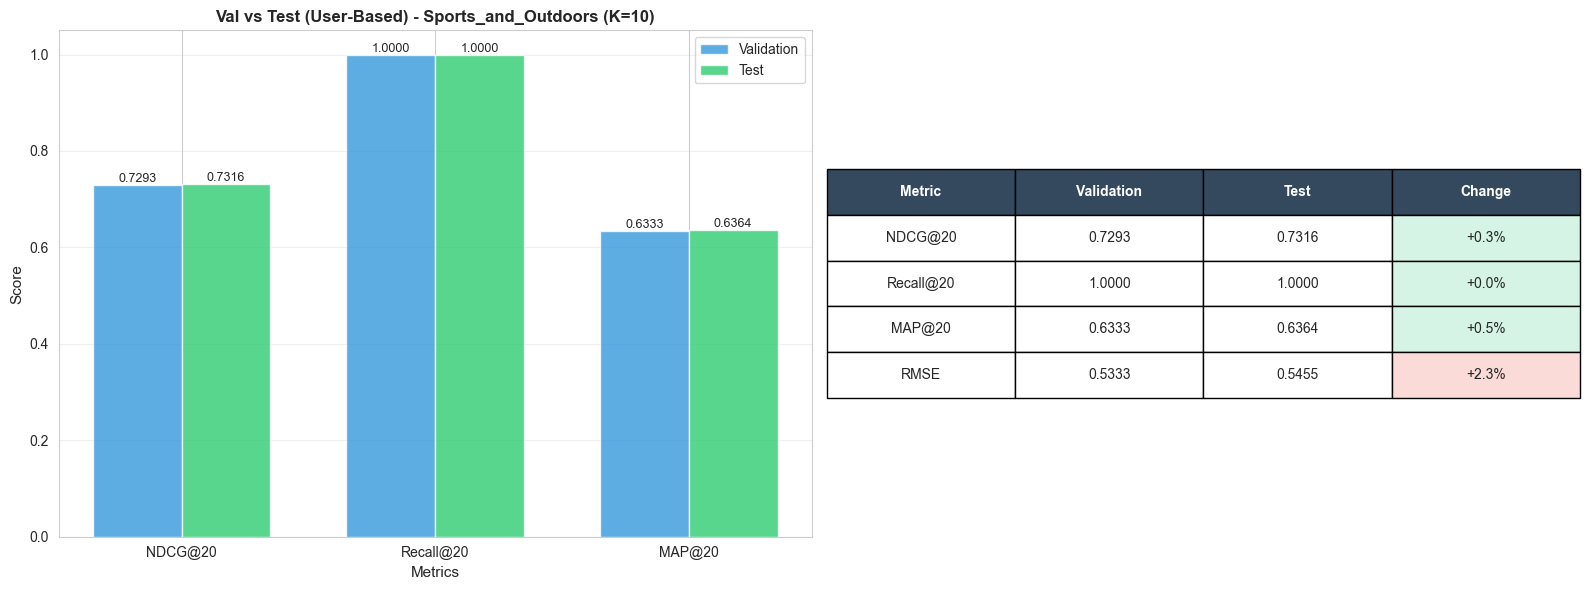

2025-10-26 01:47:51,224 - INFO - 
COMPLETE


In [31]:
logger.log_info("\nPHASE 2: FINAL EVALUATION\n")

if 'workflow_results' not in locals():
    workflow_results = {cat: {'best_k': Configurations.load_best_k(cat)} for cat in CATEGORY}

n_eval_final = Configurations.get_eval_samples_final()

for cat in CATEGORY:
    logger.log_info(f"\n{cat} (K={workflow_results[cat]['best_k']})")
    final_artifacts = load_user_artifacts(MODELS_DIR / "user" / cat)
    final_artifacts['k_neighbors'] = workflow_results[cat]['best_k']
    results = evaluate_user_based(cat, final_artifacts, k_values=[10, 20, 50], split="test", sample_users=n_eval_final)
    
    if results:
        workflow_results[cat]['test_results'] = results

test_results = [workflow_results[cat]['test_results'] for cat in CATEGORY if 'test_results' in workflow_results[cat]]
if test_results:
    df_final = pl.DataFrame(test_results)
    display(df_final)
    df_final.write_csv(MODELS_DIR / 'user' / 'final_test_results.csv')
    visualize_final_results(test_results, save_dir=MODELS_DIR / 'user', algo_name='User-Based', k_values=[10, 20, 50])

for cat in CATEGORY:
    tuning_csv = MODELS_DIR / 'user' / f'tuning_{cat}.csv'
    if tuning_csv.exists() and 'test_results' in workflow_results[cat]:
        df_tuning = pl.read_csv(tuning_csv)
        best_k = workflow_results[cat]['best_k']
        # print(f"\n=== DEBUG {cat} ===")
        # print(f"best_k = {best_k}, type = {type(best_k)}")
        # print(f"K column dtype = {df_tuning['K'].dtype}")
        # print(f"K values = {df_tuning['K'].to_list()}")
        # print(f"K == best_k results:")
        print(df_tuning.filter(pl.col('K') == best_k))


        tuning_row = df_tuning.filter(pl.col('K') == best_k).row(0, named=True)
        final_row = df_final.filter(pl.col('category') == cat).row(0, named=True)
        visualize_val_test_comparison(cat=cat, param_val=best_k, tuning_row=tuning_row, 
            final_row=final_row, save_dir=MODELS_DIR / 'user', param_name='K', algo_name='User-Based')

logger.log_info("\nCOMPLETE")

In [32]:
def recommend_user_ui(user_id: str, n_recs: int = 5, models_dir: str | Path | None = None, category: str | None = None):
    cat = category or CATEGORY[0]
    model_dir = Path(models_dir) if models_dir else (MODELS_DIR / "user" / cat)
    artifacts = load_user_artifacts(model_dir)
    artifacts['k_neighbors'] = Configurations.load_best_k(cat)
    return recommend_user_based(user_id, n_recs, artifacts)

def test_all_categories():
    for cat in CATEGORY:
        try:
            model_dir = MODELS_DIR / "user" / cat
            if not model_dir.exists():
                continue
            artifacts = load_user_artifacts(model_dir)
            user_rev = artifacts['user_rev']
            if len(user_rev) > 0:
                recs = recommend_user_ui(user_rev[0], n_recs=N_RECS, category=cat)
                display(recs)
        except Exception as e:
            logger.log_exception(f"{cat}: {e}")

In [33]:
test_all_categories()

parent_asin,score
str,f64
"""B075X8471B""",4.073128
"""B01K8B8YA8""",4.073056
"""B0BGNG1294""",4.060844
"""B07P9V8GSH""",4.057821
"""B07S764D9V""",4.04659
"""B00FB50S0Q""",4.044191
"""B071R715MZ""",4.038499
"""B0BS2ZMHCL""",4.037906
"""B0BN74ZJDK""",4.037902


parent_asin,score
str,f64
"""B0B6QVGZ4X""",5.0
"""B0BVW6XYNZ""",5.0
"""B09GN3GC8G""",5.0
"""B07YT2VKTG""",5.0
"""B0C4K2HYLZ""",5.0
"""B09GN3GC8C""",5.0


parent_asin,score
str,f64
"""B08HWP19XK""",5.0
"""B0BX5QFWQN""",5.0
